In [164]:
%pylab inline
%matplotlib inline
import math
from tqdm import tqdm_notebook

Populating the interactive namespace from numpy and matplotlib


## Problem Constants

In [165]:
r0 = 2.
k = 1
omega = 1
c = omega / k
L = 10
npoints = 1024
xmax = 60

In [166]:
points = np.linspace(-xmax/2, xmax/2, npoints)
dx = points[1] - points[0]

In [167]:
ωmax = 2 * np.pi / dx
freq  = np.linspace(-ωmax/2, ωmax/2, npoints, endpoint=False)

In [168]:
h=1

## Gaussian Process and Random Medium

In order to simplify computations, we assume $z_c = h$, and $\frac Lh \in \mathbb{N}$.

In [169]:
def random_medium(zc, xc, sigma):
    # Simplification assertions.
    assert zc == h
    assert int(L/h) == L/h
    
    mus = np.zeros((npoints, int(math.ceil(L/zc))))

    R = sigma**2* np.exp(-(points / xc) ** 2)
    Rhat = np.fft.fft(np.fft.fftshift(R))

    for i in range(int(math.ceil(L/zc))):
        # For each z-band, we generate a new Gaussian process.
        # First, we generate a Gaussian white noise.
        W= np.random.randn(npoints)

        # Then we use FFT to generate the Gaussian Process.
        F = np.fft.ifft(np.sqrt(Rhat) * np.fft.fft(W))
        mus[:, i] = np.real(F)

    return mus

## Propagation operators

### Homogeneous medium D (differential) operator

In [170]:
def D(Phi, h, k):
    # The Differential D operator is a simple multiplication in Fourier domain.
    # h is the size of the step.
    Phihat = np.fft.fftshift(np.fft.fft(Phi))
    Phihat *= np.exp(-1j * freq**2 * h/(2*k))
    Phit = np.fft.ifft(np.fft.ifftshift(Phihat))
    return Phit

### Inhomogeneous medium N (non linear) operator

In [171]:
def N(Phi, h, k, mu):
    # The Non-Linear operator N is a simple multiplication in time domain?
    # h is the size of the step, which is also supposed to be equal to the width of the potential μ.
    return Phi * np.exp(1j * k/2 * h * mu)

### Split Step Fourier operator

In [172]:
def ssf(Phi, mus, k, h):
    # Applies Split Step Fourier operator to approximate the global solution.
    
    # TODO: Merge contiguous half steps?
    for i in range(int(math.ceil(L/zc))):
        # Linear half step:
        Phi = D(Phi, h/2, k)

        # Non linear step:
        Phi = N(Phi, h, k, mus[:, i])

        # Linear half step:
        Phi = D(Phi, h/2, k)
    return Phi

## Time Reversal Operators

### Time reversal mirror

In [173]:
def mirror_tr(Phi, mirror):
    return np.conj(Phi) * mirror

### Time Reversal Mirror in homogeneous medium

In [174]:
def D_tr(Phi, h, k, mirror):
    Phit = D(Phi, h, k)
    Phitr = mirror_tr(Phit, mirror)
    return D(Phitr, h, k)

### Time Reversal Mirror in random medium

In [175]:
def ssf_tr(Phi, mus, k, h, mirror):
    Phit = ssf(Phi, mus, k, h)
    Phitr = mirror_tr(Phit, mirror)
    return ssf(Phitr, mus[:,::-1], k, h)

### Hybrid Time Reversal (Random forward and Homogenous backward mediums)

In [176]:
def hybrid_tr(Phi, mus, k, h, mirror):
    Phit = ssf(Phi, mus, k, h)
    Phitr = mirror_tr(Phit, mirror)
    return D(Phitr, int(math.ceil(L/zc)), k)

# Experiments

In [177]:
Phi0 = np.exp(-(points / r0)**2)

## 1) Propagation of time-harmonic waves in a homogeneous medium

In [178]:
Phit = D(Phi0, L, k)

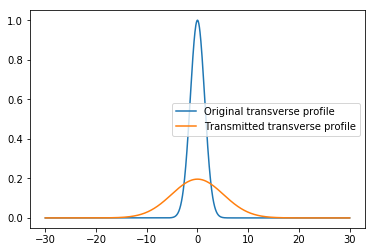

In [179]:
plt.plot(points, Phi0, label='Original transverse profile')
plt.plot(points, np.absolute(Phit)**2, label='Transmitted transverse profile')
plt.legend()
plt.show()

### Theoretical Formulas

In [180]:
def theory_rt(k):
    return r0 * np.sqrt(1 + 2j * L / (k * r0**2))

def theory_Rt(k):
    return r0 * np.sqrt(1 + ((2 * L) / (k * r0**2)) ** 2)

def theory_Phit(k):
    rt = theory_rt(k)
    return r0 / rt * np.exp(- (points / rt) ** 2)

def theory_Phit_2(k):
    Rt = theory_Rt(k)
    return r0 / Rt * np.exp(-2*(points / Rt)**2)

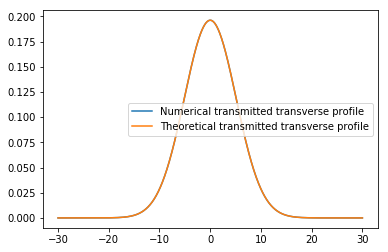

In [183]:
plt.plot(points, np.absolute(Phit)**2, label='Numerical transmitted transverse profile')
plt.plot(points, np.abs(theory_Phit(k)) ** 2, label='Theoretical transmitted transverse profile')
plt.legend()
plt.show()

## 2) Time reversal for time-harmonic waves in a homogeneous medium

### Time reversal mirrors

In [73]:
rM = 10

In [74]:
# Compactly supported mirror.
def compact_mirror(r):
    return (1 - (points/(2*r))**2) ** 2 * (np.abs(points) <= 2*r)

# Gaussian mirror.
def gaussian_mirror(r):
    return np.exp(- (points/r) ** 2)

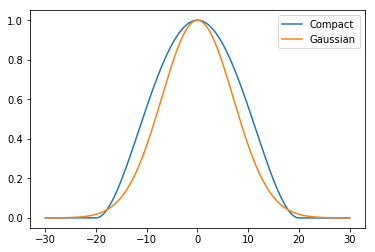

In [75]:
plt.plot(points, compact_mirror(rM), label='Compact')
plt.plot(points, gaussian_mirror(rM), label='Gaussian')
plt.legend()
plt.show()

### Time Reversal with Compact and Gaussian mirror

In [76]:
rM = 10

In [77]:
Phi_tr_compact = D_tr(Phi0, L, k, compact_mirror(rM))
Phi_tr_gaussian = D_tr(Phi0, L, k, gaussian_mirror(rM))

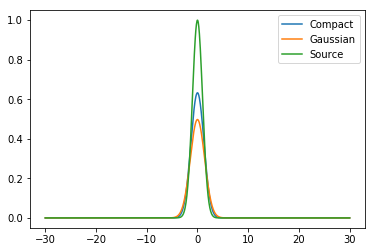

In [78]:
plt.plot(points, np.absolute(Phi_tr_compact)**2, label='Compact')
plt.plot(points, np.absolute(Phi_tr_gaussian)**2, label='Gaussian')
plt.plot(points, np.absolute(Phi0)**2, label='Source')
plt.legend()
plt.show()

### Theoretical Formulas for Gaussian Mirror Time Reversal

In [79]:
def theory_rtr(rM, k):
    return np.sqrt(1 / (1/rM**2 + 1/(r0**2-2 * 1j * L/k)) + 2 * 1j * L/k)

def theory_atr(rM, k):
    return np.sqrt(1 + (2 * L / (k * r0 * rM)) ** 2 + 2 * 1j * L/(k*rM**2))

def theory_gaussian_Phitr(rM, k):
    atr = theory_atr(rM, k)
    rtr = theory_rtr(rM, k)
    return 1/atr * np.exp(-(points/rtr)**2)

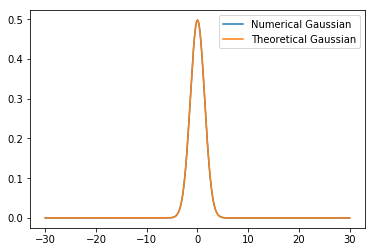

In [189]:
plt.plot(points, np.absolute(Phi_tr_gaussian)**2, label='Numerical Gaussian')
plt.plot(points, np.absolute(theory_gaussian_Phitr(rM, k))**2, label='Theoretical Gaussian')
plt.legend()
plt.show()

### Refocusing quality with mirror radius

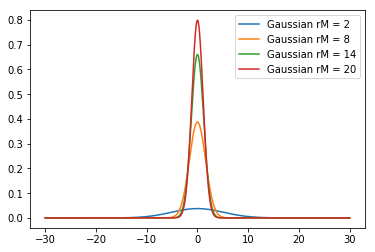

In [187]:
radii = np.linspace(2, 20, 4)
for r in radii:
    plt.plot(points, np.absolute(D_tr(Phi0, L, k, gaussian_mirror(r))) ** 2, label='Gaussian rM = {}'.format(int(r)))
plt.legend()
plt.show()

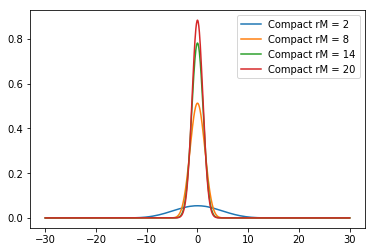

In [188]:
radii = np.linspace(2, 20, 4)
for r in radii:
    plt.plot(points, np.absolute(D_tr(Phi0, L, k, compact_mirror(r))) ** 2, label='Compact rM = {}'.format(int(r)))
plt.legend()
plt.show()

## 3) Propagation of time-harmonic waves in a random medium

### Random Medium parameters

In [190]:
zc = 1
xc = 4
sigma = 1

In [191]:
μ = random_medium(zc, xc, sigma)

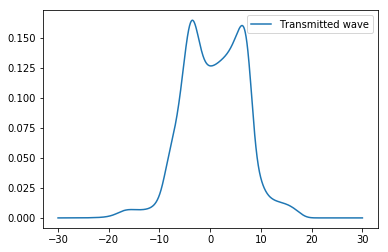

In [192]:
plt.plot(points, np.absolute(ssf(Phi0, μ, k, h))**2, label='Transmitted wave')
plt.legend()
plt.show()

### Theoretical Formulas

In [195]:
def theory_gamma0(sigma, zc):
    return sigma ** 2 * zc

def theory_Phit_random(omega, sigma, zc):
    k = omega / c
    rt = theory_rt(k)
    return r0 / rt * np.exp(- (points / rt) ** 2) * np.exp(-theory_gamma0(sigma, zc)/8 * L * omega**2)

### Average transmitted wave profile

<IPython.core.display.Javascript object>


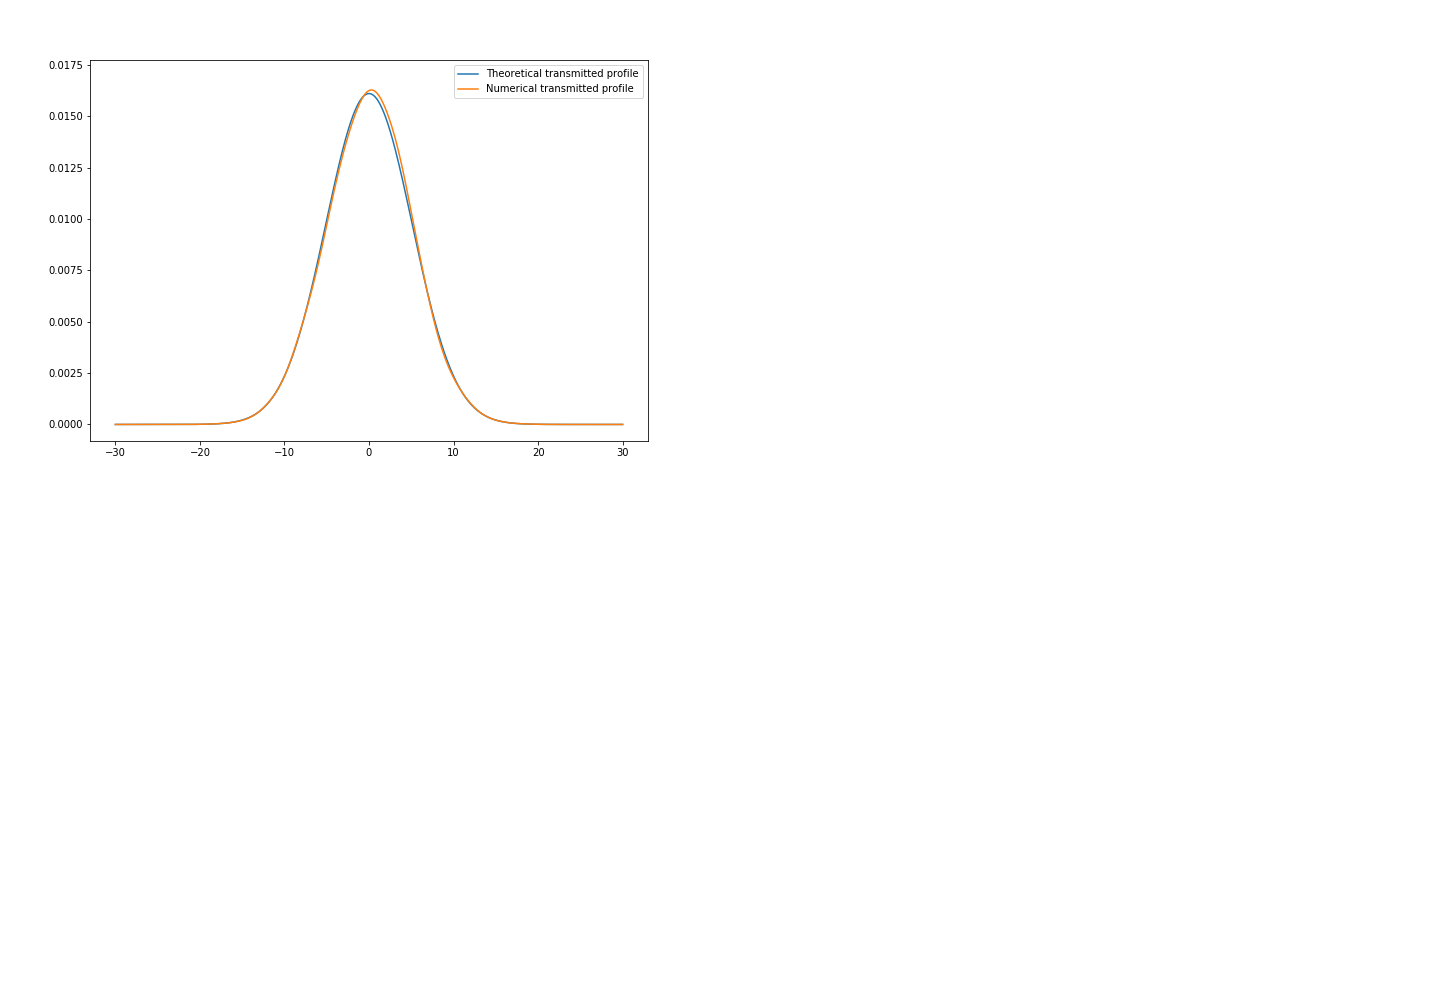

In [196]:
xc = 4
zc = 1
sigma = 1
N_avg = 10000
plot_period = 200

%matplotlib notebook
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

theory_avg_Phit = np.absolute(theory_Phit_random(omega, sigma, zc)) ** 2
avg_Phit = np.zeros(npoints, dtype=complex)

for i in tqdm_notebook(range(N_avg)):
    avg_Phit += ssf(Phi0, random_medium(zc, xc, sigma), k, h)
    if i % plot_period == 0 or i == N_avg - 1:
        ax.clear()
        ax.plot(points, theory_avg_Phit, label='Theoretical transmitted profile')
        ax.plot(points, np.absolute(avg_Phit / (i+1)) ** 2, label='Numerical transmitted profile')
        ax.set_ylim(-0.05 * np.max(theory_avg_Phit), np.max(theory_avg_Phit)*1.1)
        ax.legend()
        ax.plot()
        fig.canvas.draw()

avg_Phit /= N_avg

fig.show()
%matplotlib inline

## 4) Time reversal for time-harmonic waves in a random medium

### Gaussian Mirror Time Reversal

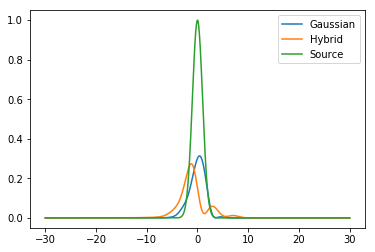

In [87]:
μ = random_medium(zc, xc, sigma)
plt.plot(points, np.absolute(ssf_tr(Phi0, μ, k, h, gaussian_mirror(rM)))**2, label='Gaussian')
plt.plot(points, np.absolute(hybrid_tr(Phi0, μ, k, h, gaussian_mirror(rM)))**2, label='Hybrid')
plt.plot(points, np.absolute(Phi0)**2, label='Source')
plt.legend()
plt.show()

### Theoretical Formulas

In [88]:
def theory_gamma2(sigma, zc, xc):
    return 2 * sigma ** 2 * zc / xc ** 2

def theory_ra(sigma, zc, xc, omega):
    return 1 / sqrt(theory_gamma2(sigma, zc, xc) * omega**2 * L / 48)

def theory_Phitr_random(rM, omega, sigma, zc, xc):
    k = omega / c
    rtr = theory_rtr(rM, k)
    atr = theory_atr(rM, k)
    ra = theory_ra(sigma, zc, xc, omega)
    return 1 / atr * np.exp(- (points / rtr) ** 2) * np.exp(- (points / ra) ** 2)

def theory_Phitr_hybrid(rM, omega, sigma, zc):
    k = omega / c
    rtr = theory_rtr(rM, k)
    atr = theory_atr(rM, k)
    return 1 / atr * np.exp(- (points / rtr) ** 2) * np.exp(-theory_gamma0(sigma, zc)/8 * L * omega**2)

### Average refocused wave profile

<IPython.core.display.Javascript object>


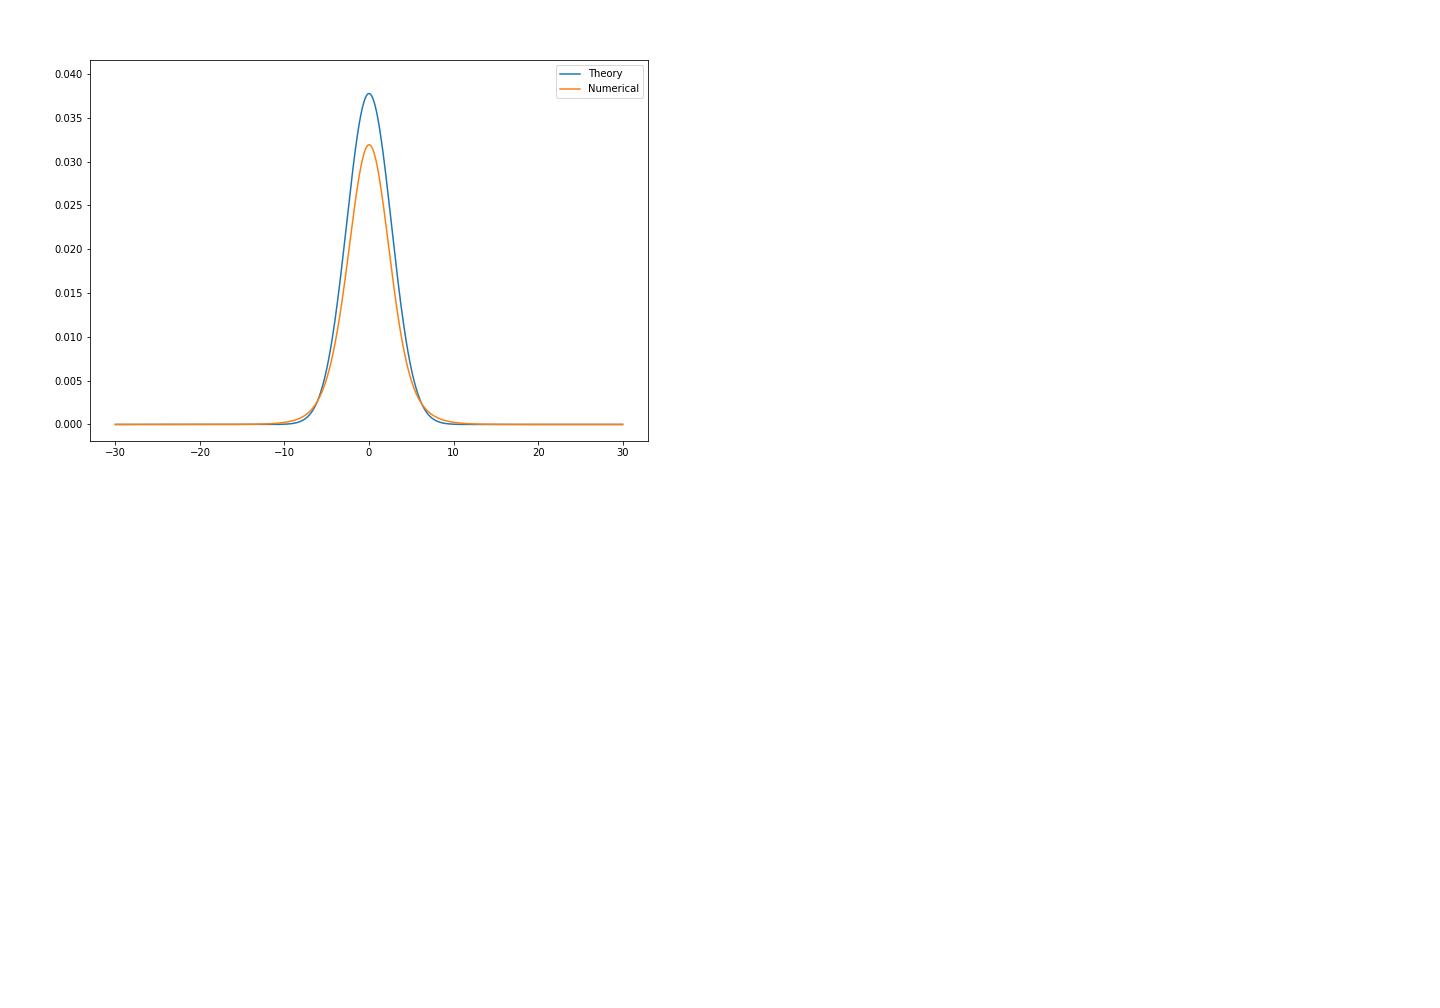

In [89]:
xc = 4
zc = 1
sigma = 1

rM = 2

N_avg = 10000
plot_period = 200

%matplotlib notebook
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

theory_avg_Phitr = np.absolute(theory_Phitr_random(rM, omega, sigma, zc, xc)) ** 2
avg_Phitr = np.zeros(npoints, dtype=complex)

for i in tqdm_notebook(range(N_avg)):
    avg_Phitr += ssf_tr(Phi0, random_medium(zc, xc, sigma), k, h, gaussian_mirror(rM))
    if i % plot_period == 0 or i == N_avg - 1:
        ax.clear()
        ax.plot(points, theory_avg_Phitr, label='Theory')
        ax.plot(points, np.absolute(avg_Phitr / (i+1)) ** 2, label='Numerical')
        ax.set_ylim(-0.05 * np.max(theory_avg_Phitr), np.max(theory_avg_Phitr)*1.1)
        ax.legend()
        ax.plot()
        fig.canvas.draw()

avg_Phitr /= N_avg

fig.show()
%matplotlib inline

**TODO: Results don't match perfectly!**

### Average refocused wave profile for Hybrid settings

<IPython.core.display.Javascript object>


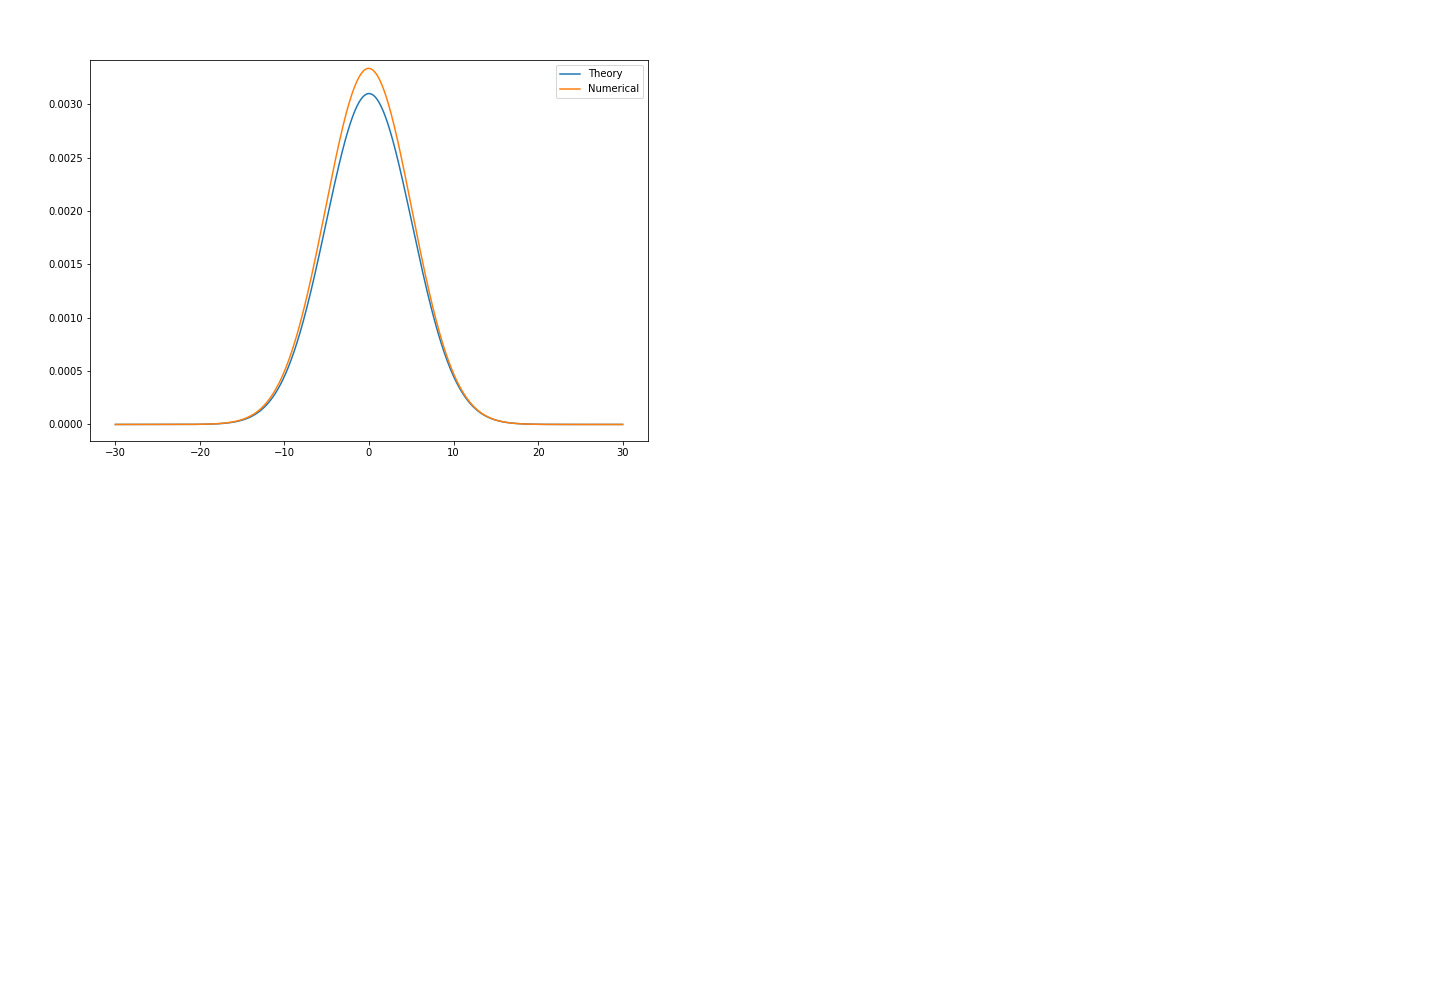

In [90]:
xc = 4
zc = 1
sigma = 1

rM = 2

N_avg = 10000
plot_period = 200

%matplotlib notebook
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

theory_avg_Phitr_hybrid = np.absolute(theory_Phitr_hybrid(rM, omega, sigma, zc)) ** 2
avg_Phitr_hybrid = np.zeros(npoints, dtype=complex)

for i in tqdm_notebook(range(N_avg)):
    avg_Phitr_hybrid += hybrid_tr(Phi0, random_medium(zc, xc, sigma), k, h, gaussian_mirror(rM))
    if i % plot_period == 0 or i == N_avg - 1:
        ax.clear()
        ax.plot(points, theory_avg_Phitr_hybrid, label='Theory')
        ax.plot(points, np.absolute(avg_Phitr_hybrid / (i+1)) ** 2, label='Numerical')
        ax.set_ylim(-0.05 * np.max(theory_avg_Phitr_hybrid), np.max(theory_avg_Phitr_hybrid)*1.1)
        ax.legend()
        ax.plot()
        fig.canvas.draw()

avg_Phitr_hybrid /= N_avg

fig.show()
%matplotlib inline

**TODO: Does not match theory!**

## 5) Time reversal for time-dependent waves in a random medium

In [159]:
ω0 = 1
B = 0.75
N_freq = 20
ωs = np.linspace(ω0-B, ω0+B, N_freq)

In [160]:
def ssf_tr_time(Phi0, μ, ωs, h, mirror):
    res = np.zeros((len(ωs), npoints), dtype=complex)
    for (i, ω) in enumerate(ωs):
        res[i] = ssf_tr(Phi0, μ, ω/c, h, mirror)
    return res

In [161]:
rM = 10

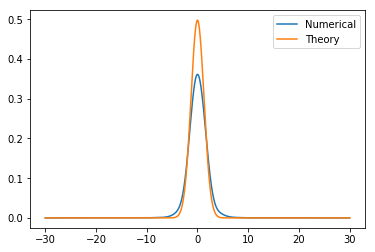

In [162]:
Phi_tr_time = ssf_tr_time(Phi0, random_medium(zc, xc, sigma), ωs, h, gaussian_mirror(rM))
Phi_tr_time_mod = np.mean(np.absolute(Phi_tr_time) ** 2, axis=0)

plt.plot(points, Phi_tr_time_mod, label='Numerical')
plt.plot(points, np.absolute(theory_Phitr_random(rM, ω0, sigma, zc, xc)) ** 2, label='Theory')
plt.legend()
plt.show()

**TODO: It sometimes corresponds to theory, but not often!**